# Model from Kakaria & de Bevort, 2017

<img src="Kakaria.png" alt="drawing" width="250"/>

In [7]:
import cx_fbl.cx_lib as cxlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Get the FBL client automatically created for
# the NeuroNLP window and attach the NeuroGFX window
# to the FBL client.

client = fbl.get_client()
for i in fbl.widget_manager.widgets:
    if fbl.widget_manager.widgets[i].widget_id not in fbl.client_manager.clients[fbl.widget_manager.widgets[i].client_id]['widgets']:
        fbl.client_manager.clients[fbl.widget_manager.widgets[i].client_id]['widgets'].append(fbl.widget_manager.widgets[i].widget_id)


In [9]:
# Initialize the constructor with the Kakaria model.
cx = cxlib.CX_Constructor(client, 'Kakaria_frontiers17')

[FBL Client NLP 2020-12-15 04:09:55] Received a message.
[FBL Client NLP 2020-12-15 04:09:55] Received a message.
[FBL Client NLP 2020-12-15 04:09:56] Received a message.
[FBL Client NLP 2020-12-15 04:09:56] Received a message.


populate the circuit diagram with parameters of the components

In [12]:
cx.initialize_diagram_config()

sending circuit configuration to GFX


Connectivity matrix between the neurons

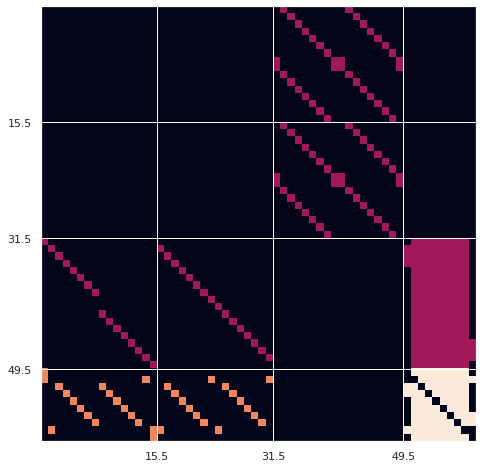

In [14]:
all_synapses = {n[1]['name']: n[0] for n in cx.data.nodes(data=True) if n[1]['class'] == 'AlphaSynapse'}
all_neurons = [n[1]['name'] for n in cx.data.nodes(data=True) if n[1]['class'] == 'LeakyIAFwithRefractoryPeriod']

a=sorted(cx.neurons_of_family('PB').items())
b=[a[i] for i in [4,5,2,1,0,6,7,8,3,9]]
neurons = sum(list([cx.neuron_uid_by_family('PB-EB-NO', 'PB/L{}'.format(10-i), 's') for i in range(1,10)]),[]) + \
          sum(list([cx.neuron_uid_by_family('PB-EB-NO', 'PB/R{}'.format(i), 's') for i in range(1,10)]),[]) + \
          sum(list([cx.neuron_uid_by_family('PB-EB-LAL', 'PB/L{}'.format(10-i), 's') for i in range(1,10)]),[]) + \
          sum(list([cx.neuron_uid_by_family('PB-EB-LAL', 'PB/R{}'.format(i), 's') for i in range(1,10)]),[]) + \
          sum(list([cx.neuron_uid_by_family('EB-LAL-PB', 'PB/L{}'.format(10-i), 'b') for i in range(1,10)]),[]) + \
          sum(list([cx.neuron_uid_by_family('EB-LAL-PB', 'PB/R{}'.format(i), 'b') for i in range(1,10)]),[]) + \
          [n[1] for n in b]

neuron_names = {cx.data.nodes[n]['name']: i for i, n in enumerate(neurons)}

connectivity = np.zeros((len(neuron_names), len(neuron_names)))
for synapse, rid in all_synapses.items():
    pre, post = synapse.split('_in_')[0].split('->')
    connectivity[neuron_names[pre], neuron_names[post]] += cx.data.nodes[rid]['gmax']

fig, ax = plt.subplots(1, 1, figsize = (8, 8))
plt.imshow(connectivity)
ax.set_xticks([15.5, 31.5, 49.5], minor = False)
ax.set_yticks([15.5, 31.5, 49.5], minor = False)
ax.xaxis.grid(True, which = 'major')
ax.yaxis.grid(True, which = 'major')

In [15]:
res = cx.remove_components()

[FBL Client NLP 2020-12-15 04:10:10] Received a message.
[FBL Client NLP 2020-12-15 04:10:10] Received a message.


Specify inputs, what to result to record

In [16]:
import itertools
shape = (200, 360)
dt = 1e-4
dur = 35.0
steps = int(dur/dt)
video_type = 'moving_bar_test'
bar_width = 50
EB_video_config = {'type': video_type,
                   'bar_width': bar_width,
                   'start': 1.0,
                   'stop': 35.,
                   'record': None,
                   'record_interval': 1000 #record every 100 steps of input video
                  }
EB_rf_config = {'num_glomeruli': 16}

EB_subregions = ['EB/L{}'.format(i) for i in range(1,9)] + \
                ['EB/R{}'.format(i) for i in range(1,9)]
EB_rids = itertools.chain.from_iterable([cx.neuron_uid_by_family('EB-LAL-PB', k) for k in EB_subregions])
EB_neurons = {rid: cx.data.nodes[rid] for rid in EB_rids}

# Since the PB-EB-LAL neuron is a PB neuron, it will be executed in the PB LPU.
# So we first create an entry for PB in the input_processors dict,
# with name "PB_InputProcessor" (See cx_fbl.cx_input).
# All the parameters should be spelt out in the dict.
# Additional input processors can be specified by extending the list.
# We do the same for 'BU' and 'bu' with "BU_InputProcessor".
input_processors = {'EB': [{'class': 'EB_Kakaria_InputProcessor',
                            'name': 'EB',
                            'module': 'cx_fbl.cx_input', # this is where PB_InputProcessor should be imported from
                            'shape': shape,
                            'dt': dt,
                            'dur': dur,
                            'video_config': EB_video_config,
                            'rf_config': EB_rf_config,
                            'neurons': EB_neurons,
                            'scale': 1,
                            'record_file': 'EB_input.h5',
                            'record_interval': 100}]}

# Specify an output processor that is to record all nodes with an output of 'V' or 'spike_state'.
# The sample interval for voltage is every 10 steps. Spikes will be returned with spike time.
output_processors = {'PB': [{'class': 'Record',
                             'uid_dict': {#'V': {'uids': None},
                                          'spike_state': {'uids': None},
                                          #'g': {'uids': None}
                                         },
                             'sample_interval': 10}
                           ],
                     'EB': [{'class': 'Record',
                             'uid_dict': {#'V': {'uids': None},
                                          'spike_state': {'uids': None},
                                          #'g': {'uids': None}
                                         },
                             'sample_interval': 10}
                           ]
                    }
# del output_processors['PB']


execute the circuit

In [17]:
cx.execute(input_processors = input_processors,
           output_processors = output_processors,
           steps = steps, dt = dt)

[FBL Client NLP 2020-12-15 04:10:18] Received a message.
{'nlp': {'8774009101462448': {'name': 'flycircuit', 'dataset': 'flycircuit'}}, 'na': {'4612215936865916': {'name': 'flycircuit', 'dataset': 'flycircuit'}}, 'nk': {'8677317213419403': {'name': 'nk', 'version': 1.05}}}
[FBL Client NLP 2020-12-15 04:10:19] Received a message.
Execution request sent. Please wait.
[FBL Client NLP 2020-12-15 04:16:50] Receiving Execution Result for cx.  Please wait .....
[FBL Client NLP 2020-12-15 04:16:51] Received Execution Result for cx. Result stored in Client.exec_result['cx']


Get the simulation result

In [18]:
result = cx.get_result()

Show EB response

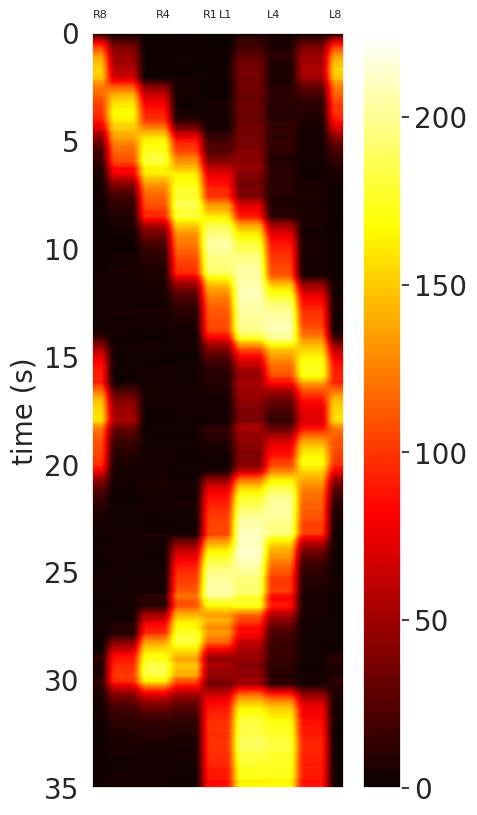

In [20]:
wedge_spike_rate = cx.show_EB_response(dur, dt, vmax = 225)

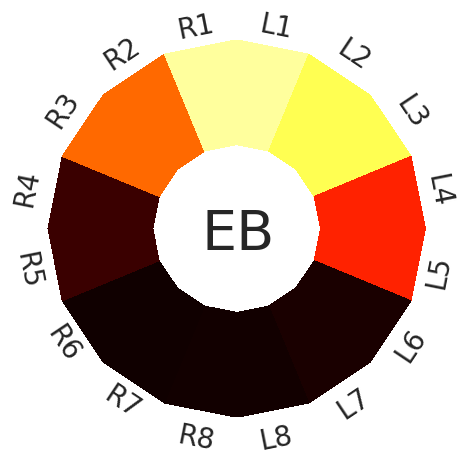

In [22]:
cx.show_EB_response_at_step(wedge_spike_rate, 100000, vmax = 225)